In [3]:
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import defaultdict
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from keras import layers

In [28]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
y_train = np.squeeze(y_train)
x_test = x_test.astype("float32") / 255.0
y_test = np.squeeze(y_test)
print(x_train[0])

[[[0.23137255 0.24313726 0.24705882]
  [0.16862746 0.18039216 0.1764706 ]
  [0.19607843 0.1882353  0.16862746]
  ...
  [0.61960787 0.5176471  0.42352942]
  [0.59607846 0.49019608 0.4       ]
  [0.5803922  0.4862745  0.40392157]]

 [[0.0627451  0.07843138 0.07843138]
  [0.         0.         0.        ]
  [0.07058824 0.03137255 0.        ]
  ...
  [0.48235294 0.34509805 0.21568628]
  [0.46666667 0.3254902  0.19607843]
  [0.47843137 0.34117648 0.22352941]]

 [[0.09803922 0.09411765 0.08235294]
  [0.0627451  0.02745098 0.        ]
  [0.19215687 0.10588235 0.03137255]
  ...
  [0.4627451  0.32941177 0.19607843]
  [0.47058824 0.32941177 0.19607843]
  [0.42745098 0.28627452 0.16470589]]

 ...

 [[0.8156863  0.6666667  0.3764706 ]
  [0.7882353  0.6        0.13333334]
  [0.7764706  0.6313726  0.10196079]
  ...
  [0.627451   0.52156866 0.27450982]
  [0.21960784 0.12156863 0.02745098]
  [0.20784314 0.13333334 0.07843138]]

 [[0.7058824  0.54509807 0.3764706 ]
  [0.6784314  0.48235294 0.16470589]


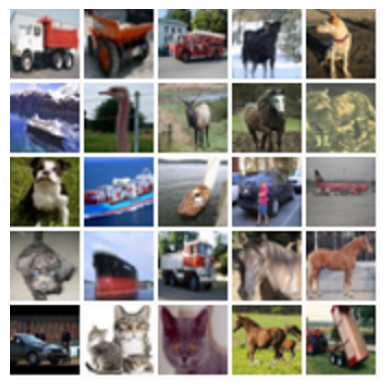

In [13]:
height_width = 32


def show_collage(examples):
    box_size = height_width + 2
    num_rows, num_cols = examples.shape[:2]

    collage = Image.new(
        mode="RGB",
        size=(num_cols * box_size, num_rows * box_size),
        color=(250, 250, 250),
    )
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            array = (np.array(examples[row_idx, col_idx]) * 255).astype(np.uint8)
            collage.paste(
                Image.fromarray(array), (col_idx * box_size, row_idx * box_size)
            )

    # Podwójny rozmiar do wizualizacji.
    collage = collage.resize((2 * num_cols * box_size, 2 * num_rows * box_size))
    return collage


# Pokaż kolaż losowych obrazów 5x5.
sample_idxs = np.random.randint(0, 50000, size=(5, 5))
examples = x_train[sample_idxs]
collage = show_collage(examples)
plt.imshow(collage)
plt.axis('off')
plt.show()

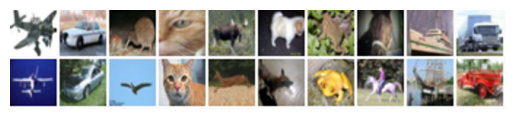

In [12]:
class_idx_to_train_idxs = defaultdict(list)
for y_train_idx, y in enumerate(y_train):
    class_idx_to_train_idxs[y].append(y_train_idx)

class_idx_to_test_idxs = defaultdict(list)
for y_test_idx, y in enumerate(y_test):
    class_idx_to_test_idxs[y].append(y_test_idx)

num_classes = 10


class AnchorPositivePairs(keras.utils.Sequence):
    def __init__(self, num_batchs):
        self.num_batchs = num_batchs

    def __len__(self):
        return self.num_batchs

    def __getitem__(self, _idx):
        x = np.empty((2, num_classes, height_width, height_width, 3), dtype=np.float32)
        for class_idx in range(num_classes):
            examples_for_class = class_idx_to_train_idxs[class_idx]
            anchor_idx = random.choice(examples_for_class)
            positive_idx = random.choice(examples_for_class)
            while positive_idx == anchor_idx:
                positive_idx = random.choice(examples_for_class)
            x[0, class_idx] = x_train[anchor_idx]
            x[1, class_idx] = x_train[positive_idx]
        return x


examples = next(iter(AnchorPositivePairs(num_batchs=1)))
collage = show_collage(examples)

plt.imshow(collage)
plt.axis('off')
plt.show()

In [14]:
class EmbeddingModel(keras.Model):
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        anchors, positives = data[0], data[1]

        with tf.GradientTape() as tape:
            anchor_embeddings = self(anchors, training=True)
            positive_embeddings = self(positives, training=True)

            # Oblicz podobieństwo kosinusowe między kotwicami i pozytywami. Ponieważ
            # zostały znormalizowane, jest to po prostu iloczyn kropek w parze.
            similarities = tf.einsum(
                "ae,pe->ap", anchor_embeddings, positive_embeddings
            )

            # Ponieważ zamierzamy użyć ich jako logitów, przeskalujemy je o temperaturę.
            # Wartość ta byłaby normalnie wybrana jako parametr hiper.
            temperature = 0.2
            similarities /= temperature

            # Używamy tych podobieństw jako logitów dla softmax. Etykiety dla
            # tego wywołania są po prostu sekwencją [0, 1, 2, ..., num_classes], ponieważ
            # chcemy, aby wartości głównej przekątnej, które odpowiadają parom kotwica/pozytywny
            # pary, aby były wysokie. Ta strata przeniesie osadzenia dla par
            # kotwic/pozytywnych par razem i rozdzieli wszystkie pozostałe pary.
            sparse_labels = tf.range(num_classes)
            loss = self.compiled_loss(sparse_labels, similarities)

        # Oblicz gradienty i zastosuj je za pomocą optymalizatora.
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))


        self.compiled_metrics.update_state(sparse_labels, similarities)
        return {m.name: m.result() for m in self.metrics}

In [15]:
inputs = layers.Input(shape=(height_width, height_width, 3))
x = layers.Conv2D(filters=32, kernel_size=3, strides=2, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, strides=2, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, strides=2, activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)
embeddings = layers.Dense(units=8, activation=None)(x)
embeddings = tf.nn.l2_normalize(embeddings, axis=-1)

model = EmbeddingModel(inputs, embeddings)
model.summary()

Model: "embedding_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 15, 15, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 global_average_pooling2d (G  (None, 128)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 8)                 1032      
                                                   

In [16]:

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

In [17]:
history = model.fit(AnchorPositivePairs(num_batchs=1000), epochs=20)

Epoch 1/20
1000/1000 [==============================] - 6s 5ms/step - loss: 2.2089
Epoch 2/20
1000/1000 [==============================] - 5s 5ms/step - loss: 2.0752
Epoch 3/20
1000/1000 [==============================] - 5s 5ms/step - loss: 2.0200
Epoch 4/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.9943
Epoch 5/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.9631
Epoch 6/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.9330
Epoch 7/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.9117
Epoch 8/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.8809
Epoch 9/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.8473
Epoch 10/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.8232
Epoch 11/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.8041
Epoch 12/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.7832
E

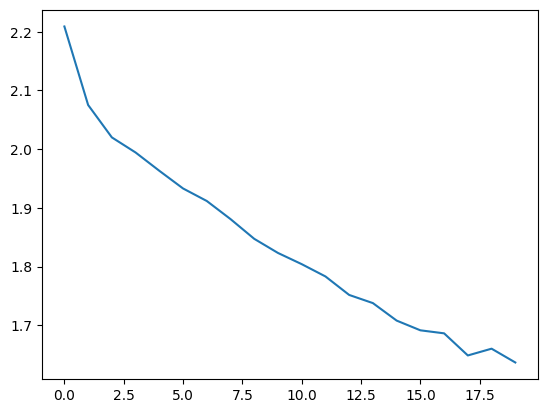

In [18]:
plt.plot(history.history["loss"])
plt.show()

313/313 [==============================] - 1s 2ms/step


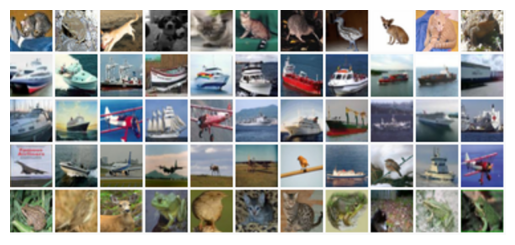

In [20]:

near_neighbours_per_example = 10

embeddings = model.predict(x_test)
gram_matrix = np.einsum("ae,be->ab", embeddings, embeddings)
near_neighbours = np.argsort(gram_matrix.T)[:, -(near_neighbours_per_example + 1) :]

num_collage_examples = 5

examples = np.empty(
    (
        num_collage_examples,
        near_neighbours_per_example + 1,
        height_width,
        height_width,
        3,
    ),
    dtype=np.float32,
)
for row_idx in range(num_collage_examples):
    examples[row_idx, 0] = x_test[row_idx]
    anchor_near_neighbours = reversed(near_neighbours[row_idx][:-1])
    for col_idx, nn_idx in enumerate(anchor_near_neighbours):
        examples[row_idx, col_idx + 1] = x_test[nn_idx]

collage2 = show_collage(examples)
plt.imshow(collage2)
plt.axis('off')
plt.show()

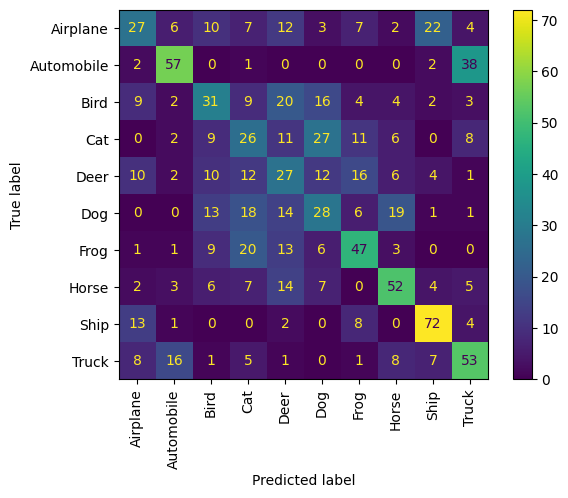

In [25]:

confusion_matrix = np.zeros((num_classes, num_classes))

# Dla każdej klasy
for class_idx in range(num_classes):
    # Rozważmy 10 przykładów.
    example_idxs = class_idx_to_test_idxs[class_idx][:10]
    for y_test_idx in example_idxs:
        # I policz klasy jego bliskich sąsiadów.
        for nn_idx in near_neighbours[y_test_idx][:-1]:
            nn_class_idx = y_test[nn_idx]
            confusion_matrix[class_idx, nn_class_idx] += 1

# Wyświetla macierz
labels = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck",
]
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="vertical")

plt.show()
